# Load and Evaluate a trained model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision.io.image import decode_jpeg, read_file
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix as sk_confusion_matrix 
from IPython.display import display

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Loading

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, binary=True):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.binary = binary

       # Add a 'label' column to the DataFrame
        if self.binary:
            self.data['label'] = self.data['real_age'].apply(lambda age: 0 if age < 25 else 1)
            self.classes = self.data['label'].unique().tolist()
        else:
            self.data['label'] = self.data['real_age']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file_name'])+'_face.jpg'
        label = row['label']

        # Load image
        #image = Image.open(img_path).convert('RGB')  # Load RGB
        image = decode_jpeg(read_file(img_path), device="cpu").to('cuda')
        image = image.float() / 255.0 
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [82]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8,1)),
    transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [83]:
train_csv = 'appa-real-release/cropped_train.csv'
val_csv = 'appa-real-release/cropped_valid.csv'
test_csv = 'appa-real-release/cropped_test.csv'

train_dir = 'appa-real-release/cropped_train'
val_dir = 'appa-real-release/cropped_valid'
test_dir = 'appa-real-release/cropped_test'


# Create datasets
train_dataset = CustomDataset(csv_file=train_csv, image_dir=train_dir, transform=train_transforms, binary=True)
val_dataset = CustomDataset(csv_file=val_csv, image_dir=val_dir, transform=val_transforms, binary=True)
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms, binary=True)

In [84]:
class_1_count, class_0_count = test_dataset.data['label'].value_counts()
print(f"{100.* (class_0_count)/(class_0_count+class_1_count):.3f}% of samples are class 0")

30.470% of samples are class 0


In [85]:
# Compute class weights
class_counts = train_dataset.data['label'].value_counts()
class_weights = 1.0 / class_counts
sample_weights = train_dataset.data['label'].map(class_weights)

# Create sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [86]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    sampler=sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

## Load Model for Evaluation

In [87]:
# Change to apropriate model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

if num_features == 512:
    resnet_arch = 'ResNet18'
elif num_features ==2048:
    resnet_arch = 'ResNet50'
else:
    resnet_arch = 'other'
    
# Add a fully connected linear layer which transforms from 512 nodes -> 1 node
# Note that we dont add a sigmoid activation function here because we use nn.BCEWithLogitsLoss(), which applies sigmoid while calculating loss
model.fc = nn.Linear(num_features, 1)

for param in model.fc.parameters():
    param.requires_grad = True

Number of features from pre-trained model 2048


In [9]:
print(f"Number of Learnable/Learned Parameters:  {sum([param.numel() for param in model.layer4.parameters() if param.requires_grad==True]) + sum([param.numel() for param in model.fc.parameters()])}")

Number of Learnable/Learned Parameters:  14966785


In [10]:
saved_model_path = './models/ResNet50_fc+layer4_2025-01-27_v2.pth'
model.load_state_dict(torch.load(saved_model_path))

# If you saved the model on a GPU and are loading it on a CPU, you can specify:
# model.load_state_dict(torch.load(saved_model_path, map_location=torch.device('cpu')))

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

C:\Users\samRb\AppData\Local\Temp\ipykernel_19928\3152138838.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(saved_model_path))


## Evaluate Model

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./logs/ --host localhost --port 6011

### Test Metrics
- Loss, Accuracy, Precision, Recall, F1-Score

In [89]:
criterion = nn.BCEWithLogitsLoss()

def test(model, device, test_loader, criterion, decision_boundary=0.5):
    model.eval()  # Set model to evaluation mode
    
    test_loss = 0
    correct = 0
    all_targets = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Compute loss
            output = model(data) # Output is logits       
            test_loss += criterion(output.squeeze(), target.float()).item()  # Sum up batch loss
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > decision_boundary).float()  # Convert probabilities to 0 or 1

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(output.cpu().numpy())
            # Update correct count (compare predictions to target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average the val loss over the entire dataset
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get more metrics
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)

    # True negative, False positive, False negative, True positive from the confusion matrix
    tn, fp, fn, tp = sk_confusion_matrix(all_targets, all_preds).ravel()

     # Calculate AUC-ROC
    fpr, tpr, thresholds = roc_curve(all_targets, all_probs)  # Compute ROC curve
    auc_roc = auc(fpr, tpr)  # Calculate AUC-ROC
    
    return test_loss, test_accuracy, precision, recall, f1, (tn,fp,fn,tp), auc_roc, fpr, tpr

Loss: 0.6748, Accuracy: 75.7112, Precision: 0.8409, Recall: 0.8025, F1-Score: 0.8213, ROC-AUC: 0.8247


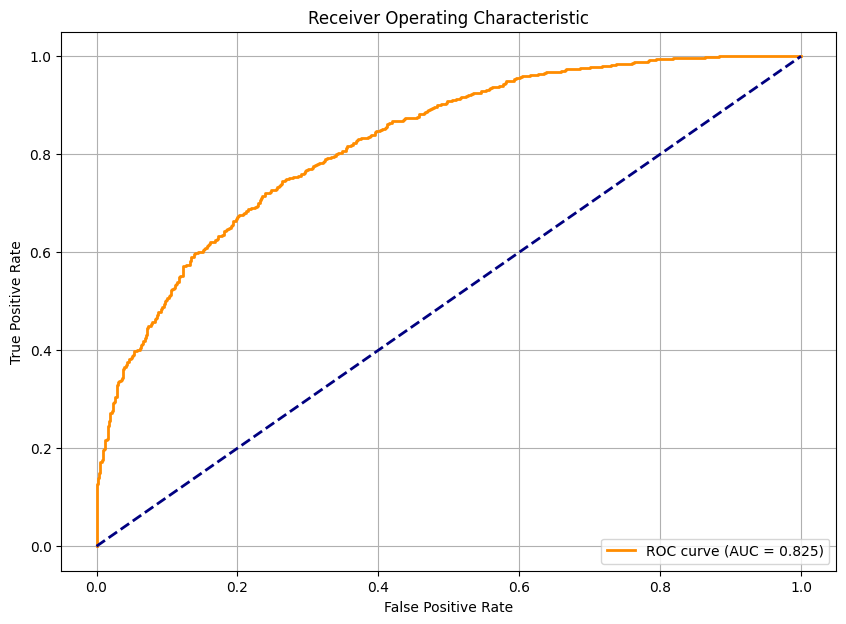

,Pred 0,Pred 1
Act 0,364,193
Act 1,251,1020


In [18]:
loss, accuracy, precision, recall, f1, conf_matrix, roc_auc, fpr, tpr = test(model, device, test_loader, criterion)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

tn, fp, fn, tp = conf_matrix 

# Create confusion matrix dataframe
conf_matrix = pd.DataFrame(
    [[tn, fp], [fn, tp]],
    columns=["Pred 0", "Pred 1"],
    index=["Act 0", "Act 1"]
)

display(conf_matrix)

### Test Predictions with Confidence

In [90]:
def visualize_model(model, num_images=6, show_fails=False, high_conf=False):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1

            for j in range(inputs.size()[0]):
                # Check if prediction matches the label
                is_misclassified = pred[j].item() != labels[j].item()

                # Skip correctly classified cases if show_fails is True
                if show_fails and not is_misclassified:
                    continue

                # Skip predictions in the range 0.25-0.75
                if high_conf and not (output[j].item() <0.2 or output[j].item()>0.8):
                    continue
                    
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {pred[j].item()}. Ground Truth: {labels[j].item()}.')
                print(f'Confidence / Model Output: {output[j].item():.3f}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = vutils.make_grid(inp)  
    inp = inp.permute(1, 2, 0) 
    
    # Convert mean and std to PyTorch tensors
    mean = torch.tensor([0.485, 0.456, 0.406], device=inp.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=inp.device)
    
    # Normalize the image
    inp = std * inp + mean
    inp = torch.clamp(inp, 0, 1)  # Ensure values are within [0, 1]
    
    # Convert the tensor to a NumPy array for visualization
    inp = inp.cpu().numpy()

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

0/1 - High confidence, ~0.5 - Low confidence
Confidence / Model Output: 0.199


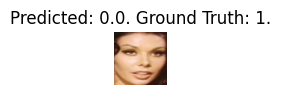

Confidence / Model Output: 0.868


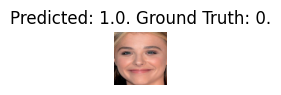

Confidence / Model Output: 0.171


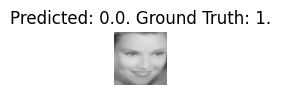

Confidence / Model Output: 0.829


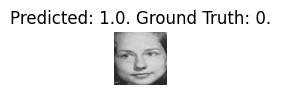

Confidence / Model Output: 0.145


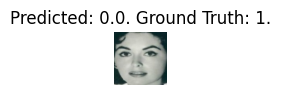

Confidence / Model Output: 0.177


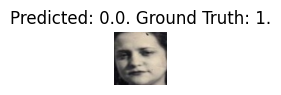

In [47]:
print('0/1 - High confidence, ~0.5 - Low confidence')
print('='*50)
visualize_model(model, num_images=12, show_fails=True, high_conf=True)

# Comparison

In [91]:
def plot_roc_curves(roc_curves):
    n_models = len(roc_curves)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 3 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, (filename, fpr, tpr, roc_auc) in enumerate(roc_curves):
        ax = axes[i]
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_title(filename, fontsize=10)
        ax.legend(loc='lower right')
        ax.grid(True)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

In [92]:
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning, message=".*torch.load.*")

models_dir = './models/'
results = []
roc_curves = []

for ix, filename in enumerate(os.listdir(models_dir)):
    model_path = os.path.join(models_dir, filename)
    if filename.endswith(".pth"):
        # Load the model
        # First make sure the architecture matches
        if 'ResNet18' in model_path:
            model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
            num_features = model.fc.in_features
        else:
            model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
            num_features = model.fc.in_features
    
        model.fc = nn.Linear(num_features, 1)
    
        # Now we can load the same model
        state_dict = torch.load(model_path, weights_only=True)
        model.load_state_dict(state_dict) # Load the weights into the model
        model.to(device)
        model.eval()
    
        loss, accuracy, precision, recall, f1, conf_matrix, auc_roc, fpr, tpr = test(model, device, test_loader, criterion, decision_boundary=0.5)
    
        tn, fp, fn, tp = conf_matrix 
        
        results.append({
            'model': filename,
            'loss': round(loss,3),
            'accuracy': round(accuracy,3),
            'precision': round(precision,3),
            'recall': round(recall,3),
            'f1-score': round(f1,3),
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'tp': tp,
            'auc_roc': round(auc_roc,3),
        })
        roc_curves.append((filename, fpr, tpr, auc_roc))
    
        print(f"{(100. * ((ix+1) / len(os.listdir(models_dir)))):.2f}%")


results_df = pd.DataFrame(results)

13.33%
20.00%
26.67%
33.33%
40.00%
46.67%
53.33%
60.00%
66.67%
73.33%
75.00%
81.25%
87.50%
93.75%


## Accuracy, Precision, Recall, F1-Score, ROC-AUC

- **Recall / True Positive Rate**
    - $\ \frac{TP}{TP + FN}$
    - Proportion of actual positives which were classified as positive
- **False Positive Rate**
    - $\ \frac{FP}{FP+TN} $
    - Proportion of all actual negatives which were classified as positive
- **Precision**
    - $\ \frac{TP}{TP + FP}$
    - Proportion of positive classification which were actually positive
- **F1-Score**
    - $\ 2\frac{Precision \cdot Recall}{Precision + Recall} = \frac{2TP}{2TP + FP + FN}$
    - Harmonic mean of precision and recall
- **ROC-AUC**
    - Represents the probability that the model, given a random positive and negative sample, ranks the positive higher than the negative
 
Note: Class 0 is negative. Class 1 is positive

,model,accuracy,precision,recall,f1-score,auc_roc,fpr
7,ResNet18__GradualUnfreeze4to1__2025-02-05_v2.pth,81.127,0.818,0.938,0.874,0.863,0.478
8,ResNet50_fc+layer4_2025-01-22_v1.pth,80.963,0.834,0.907,0.869,0.866,0.413
9,ResNet50_fc+layer4_2025-01-26_v3.pth,78.720,0.829,0.875,0.851,0.836,0.413
0,ResNet18_fc+layer4_2025-01-22_v1.pth,78.228,0.821,0.879,0.849,0.807,0.438
2,ResNet18_fc+layer4_2025-01-27_v2.pth,78.337,0.884,0.792,0.836,0.856,0.237
1,ResNet18_fc+layer4_2025-01-26_v3.pth,77.243,0.885,0.773,0.825,0.860,0.230
3,ResNet18_fc_2025-01-22_v1.pth,75.109,0.822,0.820,0.821,0.798,0.406
10,ResNet50_fc+layer4_2025-01-27_v2.pth,75.711,0.841,0.803,0.821,0.825,0.346
6,ResNet18__GradualUnfreeze1to4__2025-02-05_v2.pth,73.140,0.874,0.717,0.788,0.842,0.235
5,ResNet18_fc_2025-01-27_v2.pth,71.718,0.834,0.740,0.784,0.782,0.336


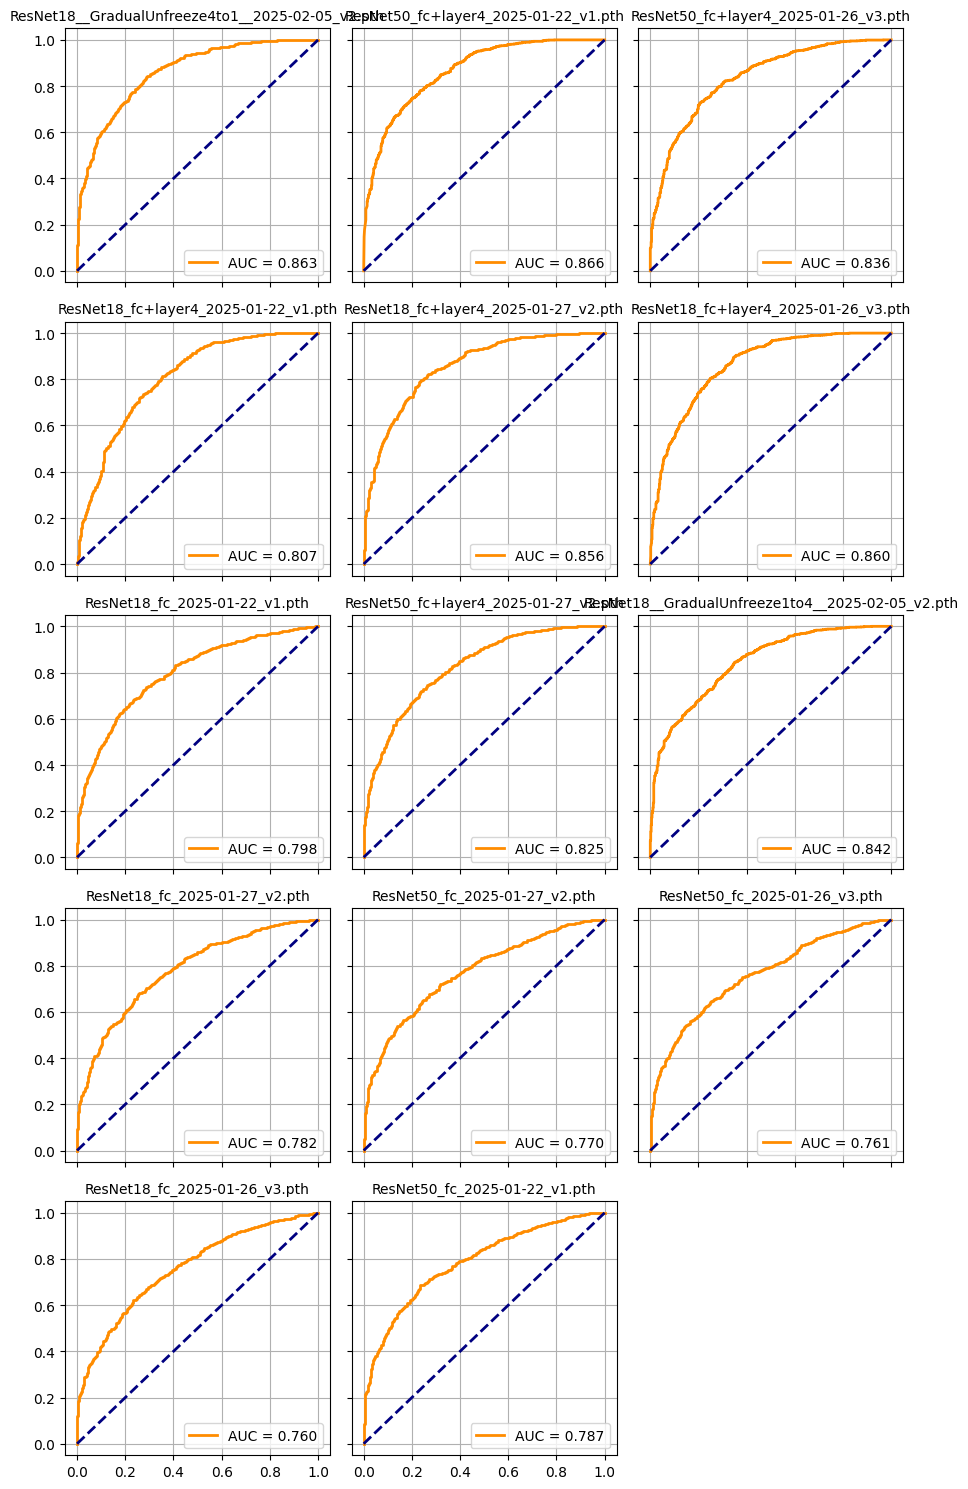

In [94]:
results_df['fpr'] = round(results_df['fp'] / (results_df['fp'] + results_df['tn']), 3)
sorted_results = results_df.sort_values(by='f1-score', ascending=False).drop(index=[])
# Show results, hiding confusion matrix values
display(sorted_results.drop(columns=['tn', 'fp', 'fn', 'tp', 'loss']))

# Sort roc curves to be ordered same as results_df then display
roc_dict = {filename: (fpr, tpr, roc_auc) for filename, fpr, tpr, roc_auc in roc_curves}
sorted_roc_curves = [(row['model'], *roc_dict[row['model']]) for _, row in sorted_results.iterrows()]
plot_roc_curves(sorted_roc_curves)

## Confusion Matrices

In [81]:
for index, row in sorted_results.iterrows():
    model_name = row['model']
    tn, fp, fn, tp = row['tn'], row['fp'], row['fn'], row['tp']
    
    # Create confusion matrix DataFrame for display
    conf_matrix_df = pd.DataFrame(
        [[tn, fp], [fn, tp]],
        columns=["Pred 0", "Pred 1"],
        index=["Act 0", "Act 1"]
    )
    
    # Normalize by total sum
    conf_matrix_total = round(conf_matrix_df / conf_matrix_df.values.sum(),2)
    
    print(f"\n{model_name}:\n")
    display(conf_matrix_total)


ResNet18_fc_2025-01-22_v1.pth:



,Pred 0,Pred 1
Act 0,0.18,0.12
Act 1,0.13,0.57



ResNet50_fc_2025-01-27_v2.pth:



,Pred 0,Pred 1
Act 0,0.20,0.10
Act 1,0.19,0.51


## Plots

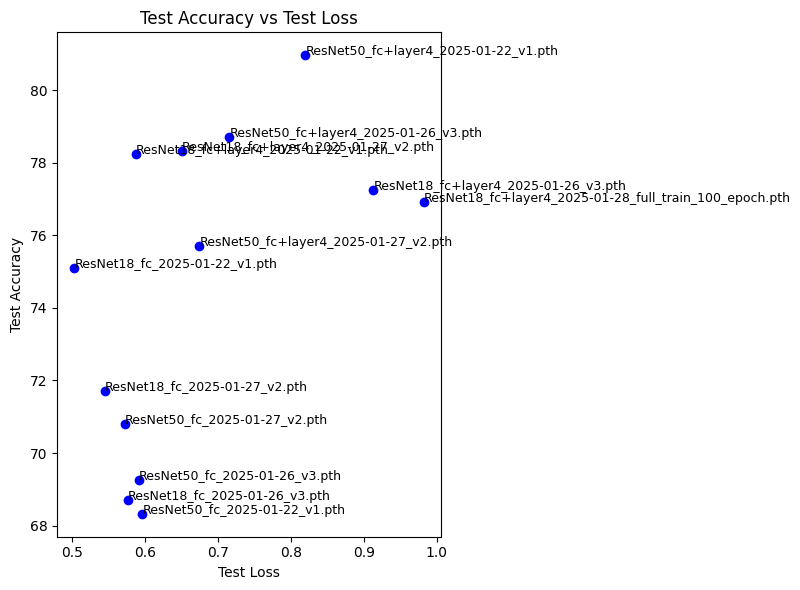

In [15]:
plt.figure(figsize=(8, 6))

# Scatter plot of Test Accuracy vs Test Loss
plt.scatter(results_df['loss'], results_df['accuracy'], color='blue')

# Annotate each point with the model name
for i, row in results_df.iterrows():
    plt.text(row['loss'], row['accuracy'], row['model'], fontsize=9)

plt.title('Test Accuracy vs Test Loss')
plt.xlabel('Test Loss')
plt.ylabel('Test Accuracy')
plt.tight_layout()
plt.show()

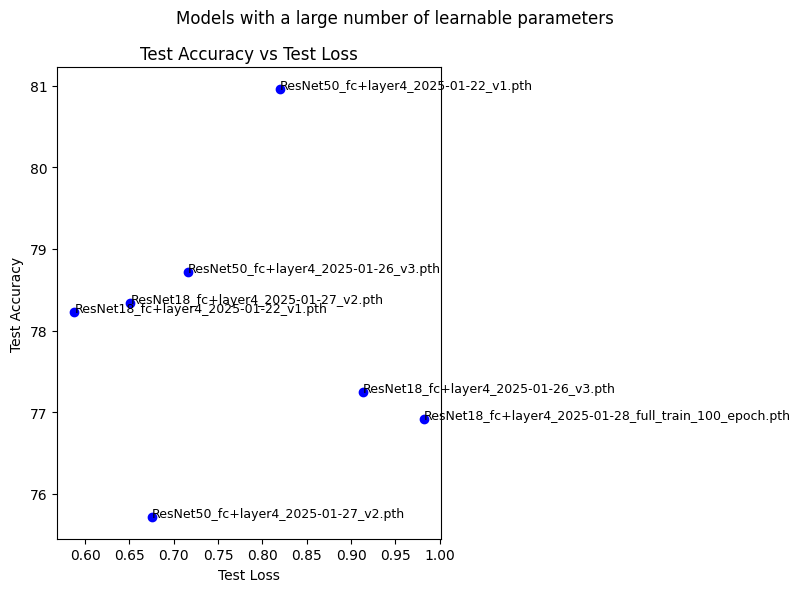

In [16]:
plt.figure(figsize=(8, 6))

filtered_df = results_df[results_df['model'].str.contains('layer4')]

# Scatter plot of Test Accuracy vs Test Loss for filtered models
plt.scatter(filtered_df['loss'], filtered_df['accuracy'], color='blue')

# Annotate each point with the model name
for i, row in filtered_df.iterrows():
    plt.text(row['loss'], row['accuracy'], row['model'], fontsize=9)

plt.title('Test Accuracy vs Test Loss')
plt.suptitle('Models with a large number of learnable parameters')
plt.xlabel('Test Loss')
plt.ylabel('Test Accuracy')
plt.tight_layout()
plt.show()

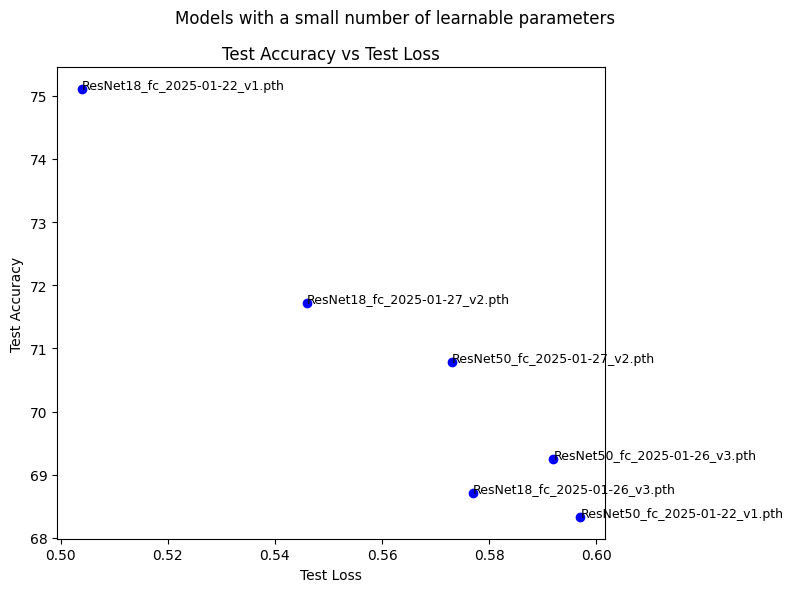

In [17]:
plt.figure(figsize=(8, 6))

filtered_df = results_df[~results_df['model'].str.contains('layer4')]

# Scatter plot of Test Accuracy vs Test Loss for filtered models
plt.scatter(filtered_df['loss'], filtered_df['accuracy'], color='blue')

# Annotate each point with the model name
for i, row in filtered_df.iterrows():
    plt.text(row['loss'], row['accuracy'], row['model'], fontsize=9)

plt.title('Test Accuracy vs Test Loss')
plt.suptitle('Models with a small number of learnable parameters')
plt.xlabel('Test Loss')
plt.ylabel('Test Accuracy')
plt.tight_layout()
plt.show()